In [41]:
from src.preprocessing import final_df
from src.models_functions import ts_pipeline, ml_pipeline, custom_train_test, lstm, prophet_predict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import warnings
import numpy as np

warnings.filterwarnings('ignore')
rcParams["figure.figsize"] = 18, 6

In [2]:
# Selecionar a ação

stock = 'bbas3'
stock = stock.upper()

In [3]:
# Criar Objetos DataFrame e Series

df = final_df(stock)

series = pd.Series(df[f"Close {stock}"])

y_train, y_test = custom_train_test(series)

In [4]:
ts_results = ts_pipeline(series)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=961.022, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.063, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=969.129, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=969.225, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=971.725, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=968.412, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=973.004, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=963.008, Time=2.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=963.006, Time=2.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=971.068, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=966.702, Time=1.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=965.558, Time=1.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=964.912, Time=2.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=960.805, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=968.2

In [5]:
prophet_dict = prophet_predict(series)

16:28:11 - cmdstanpy - INFO - Chain [1] start processing
16:28:11 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
ml_results = ml_pipeline(df, stock)

Treinando DecisionTree...
Treinando RandomForest...
Treinando XGBoost...
Treinando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 1865, number of used features: 10
[LightGBM] [Info] Start training from score 14.846001


In [7]:
lstm_dict = lstm(df, stock)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1350 - val_loss: 0.2913
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0981
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - val_loss: 0.0587
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0272
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 5.2299e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9027e-04 - val_loss: 3.0070e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4491e-04 - val_loss: 5.0972e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6335e-04 - val_loss: 4.4645e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2797e-04 - val_loss: 6.0073e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3447e-04 - val_loss: 5.6081e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━

In [13]:
neat_models_info = []

neat_models_info.append({
    "Nome do Modelo": lstm_dict["nome"],
    "Previsão": lstm_dict["predict"],
    "MAPE - Base de Teste": lstm_dict["mape_test"]
})

neat_models_info.append({
    "Nome do Modelo": prophet_dict["nome"],
    "Previsão": prophet_dict["predict"],
    "MAPE - Base de Teste": prophet_dict["mape_test"]
})

for model_name, model_info in ml_results.items():
    neat_models_info.append({
        "Nome do Modelo": model_name,
        "Previsão": model_info["predict"],
        "MAPE - Base de Teste": model_info["mape_test"]
    })

for _, row in ts_results.iterrows():
    neat_models_info.append({
        "Nome do Modelo": row["Nome do Modelo"],
        "Previsão": row["Previsão"],
        "MAPE - Base de Teste": row["MAPE"]
    })


In [15]:
neat_models_df = pd.DataFrame(neat_models_info)

In [28]:
neat_models_df["Previsão"] = neat_models_df["Previsão"].apply(lambda x: np.array(x).reshape(-1))

In [39]:
neat_models_df = neat_models_df.sort_values(by="MAPE - Base de Teste", ascending=True)

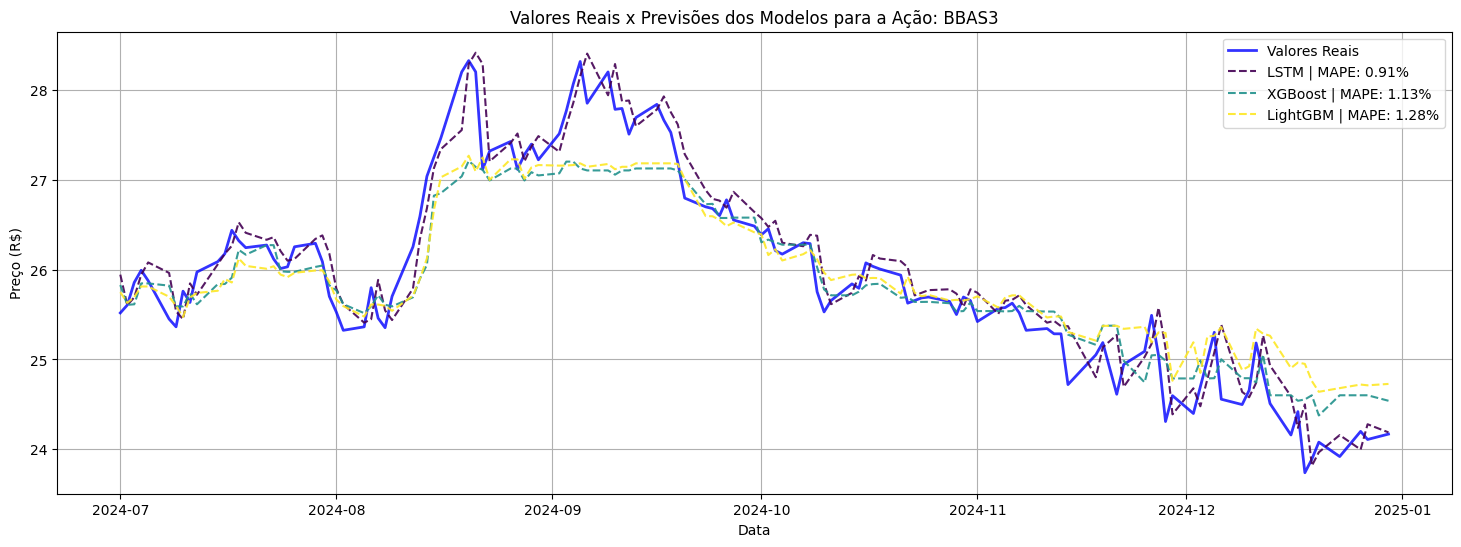

In [73]:
# Plotando as previsões dos top n modelos

top_n = 3  # Configurar parâmetro

plt.plot(y_test.index, y_test, label="Valores Reais", linewidth=2, color='blue', alpha=0.8)
colors = cm.viridis(np.linspace(0, 1, top_n))

for i, (_, row) in enumerate(neat_models_df[:top_n].iterrows()):
    nome_modelo = row["Nome do Modelo"]
    previsao = row["Previsão"]
    plt.plot(y_test.index, previsao, label=f'{nome_modelo} | MAPE: {row["MAPE - Base de Teste"] * 100:.2f}%', linestyle='--', color=colors[i], alpha=0.9)

plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.title(f"Valores Reais x Previsões dos Modelos para a Ação: {stock}")
plt.legend()
plt.grid()
plt.show()

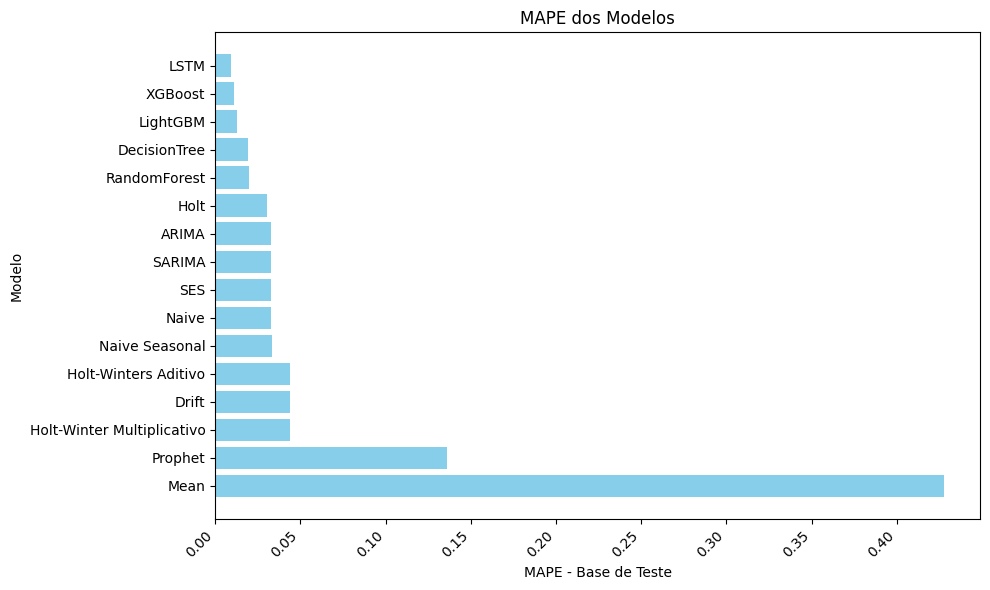

In [78]:
# Plotando os MAPES

plt.figure(figsize=(10,6))
plt.barh(neat_models_df["Nome do Modelo"], neat_models_df["MAPE - Base de Teste"], color='skyblue')

plt.xlabel("MAPE - Base de Teste")
plt.ylabel("Modelo")
plt.title("MAPE dos Modelos")
plt.xticks(rotation=45, ha='right')  # gira os nomes para melhor leitura
plt.gca().invert_yaxis()
plt.tight_layout()